In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
wmin = min(len(w) for w in words)
wmax = max(len(w) for w in words)
(wmin, wmax)

(2, 15)

In [5]:
b = {}

for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


In [6]:
# Sort by the count of the occurence of the bigram, showing most likely ones first
sb = sorted(b.items(), key= lambda kv: -kv[1])

In [7]:
import torch

(-0.5, 27.5, 27.5, -0.5)

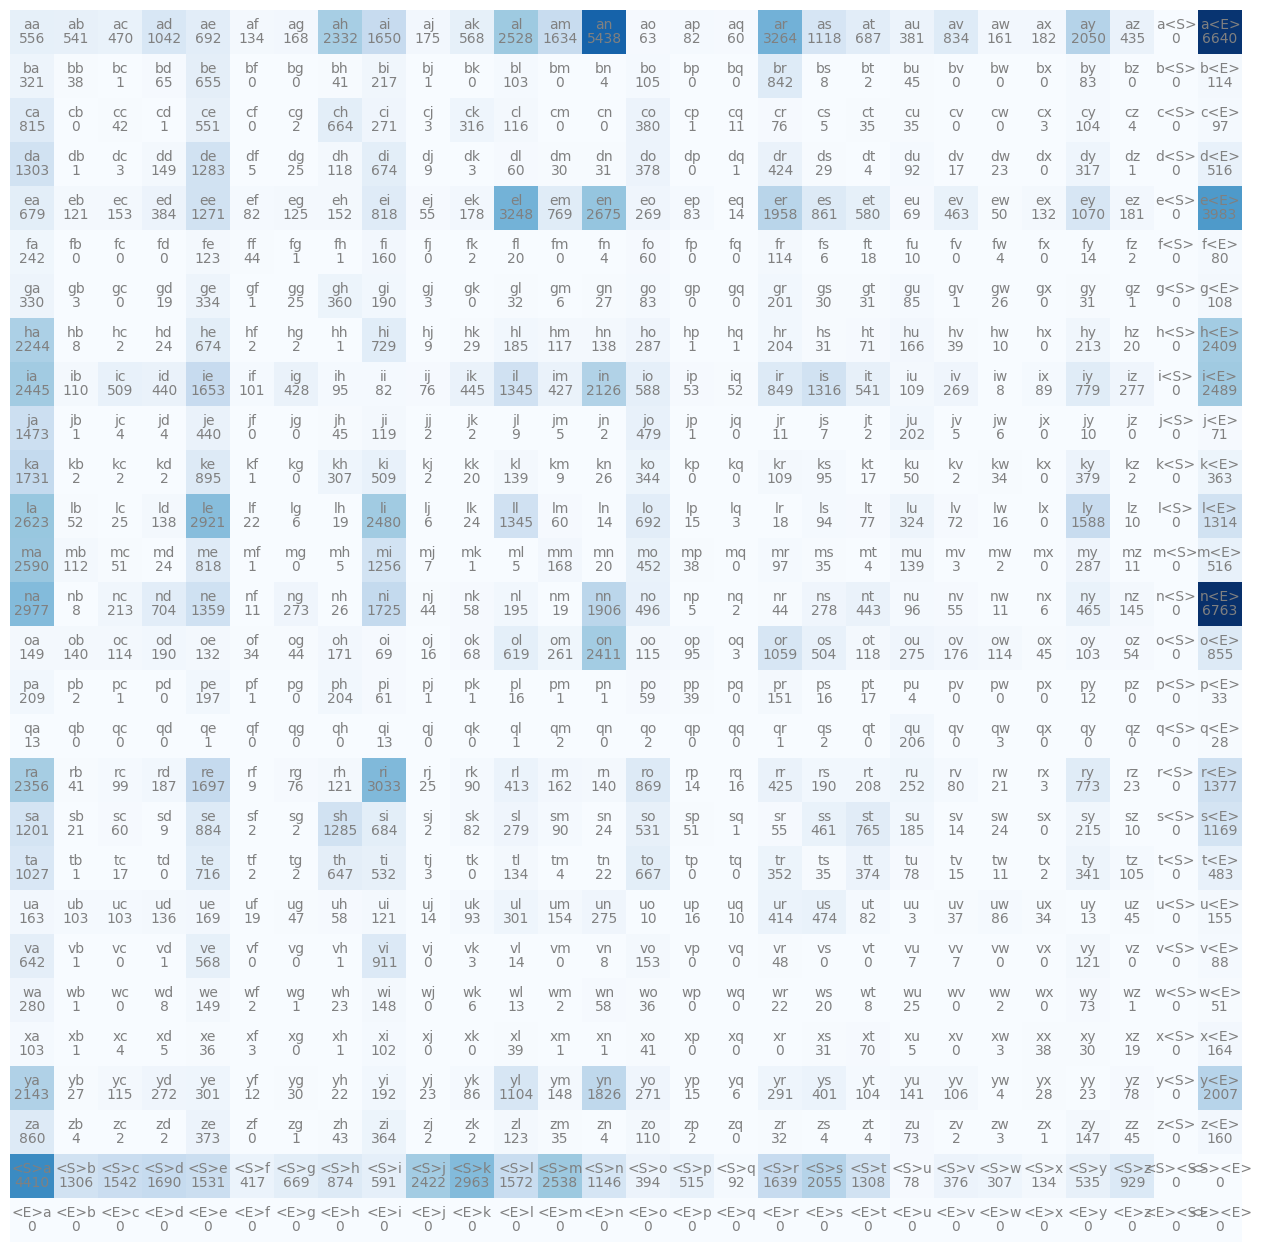

In [8]:
# First prototype with separate start and end tokens

N = torch.zeros((28,28), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = { s:i for i,s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27
itos = { i:s for s,i in stoi.items() }

# Update bigram frequency in the tensor
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
        
# Plot it
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off')


(-0.5, 26.5, 26.5, -0.5)

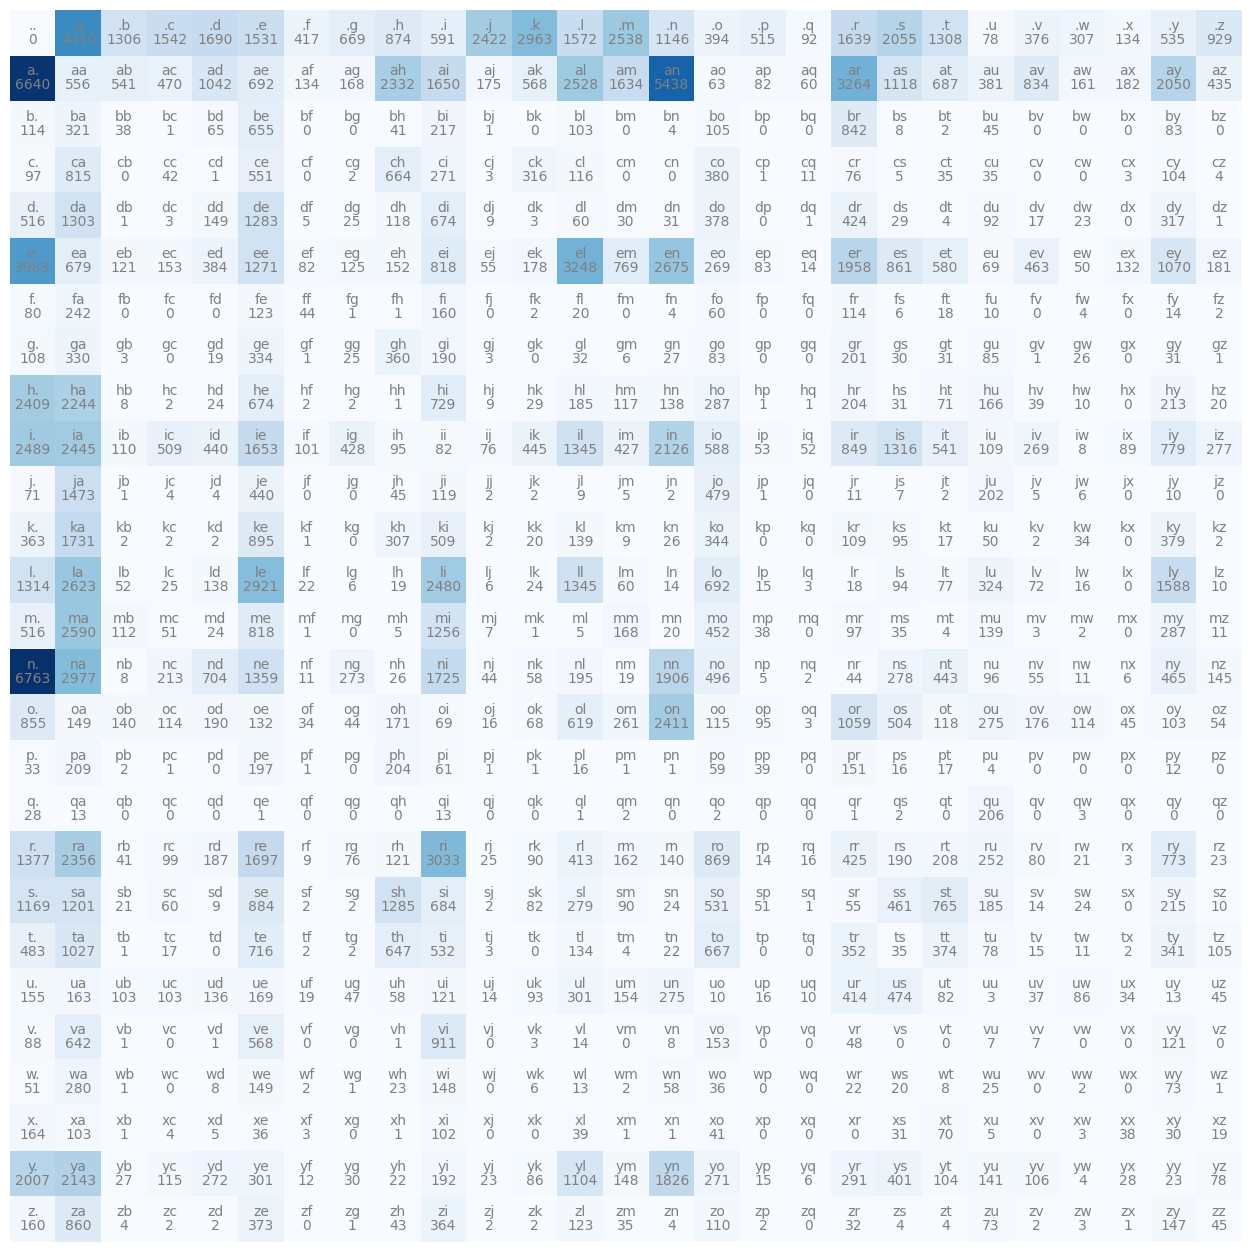

In [9]:
# Second variation with a single '.' token as start and end to deal with empty data above with 'letter<S>' and '<E>letter' patterns which will never occur
N = torch.zeros((27,27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }

# Update bigram frequency in the tensor
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
stoi
        
# Plot it
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off')


In [10]:
N[0]
p = N[0].float()
p = p / p.sum()
p


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [11]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [12]:
P = N.float()
P /= P.sum(1, keepdims=True)

(-0.5, 26.5, 26.5, -0.5)

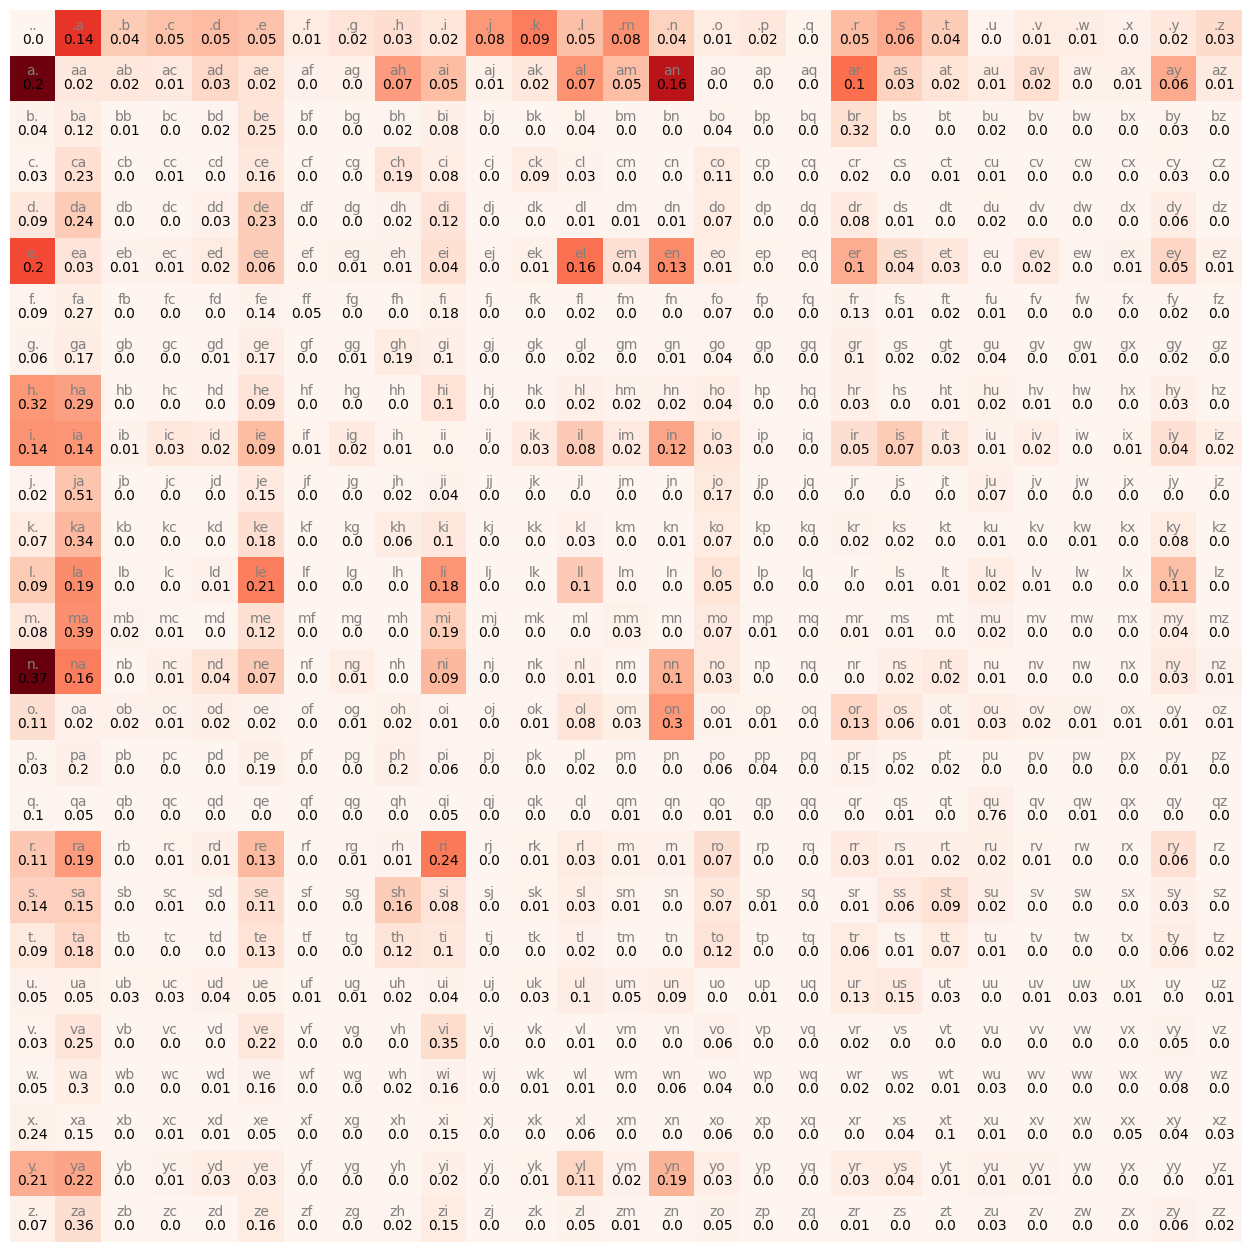

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Reds')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, str(round(P[i,j].item(),2)), ha="center", va="top", color='black')
plt.axis('off')

In [14]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


In [15]:

# GOAL: Maximize the likelihood of the data w.r.t model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log function is monotonic)
# equivalent to minimizing the negative of the log likelihood
# equivalent to minimizing the average negative log likelihood
# when the probability varies from 1 to 0, log likelihood will vary from 0 to -infinity
# since our loss functions use negative as smaller loss value, we take negative log likelihood and normalize it
# Check the effectiveness and loss function of the model
# log(a*b*c) = log(a) + log(b) + log(c)
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
print(f'Log likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative Log likelihood = {nll:.4f}')
print(f'Average Negative Log likelihood = {nll/n:.4f}')


Log likelihood = -559891.7500
Negative Log likelihood = 559891.7500
Average Negative Log likelihood = 2.4541


In [16]:
# Model smoothing - Show before smoothing is applied

# consider a case with two names:
log_likelihood = 0.0
n = 0
for w in ["aspiring", "astro", "astroqz"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        n += 1
print(f'Log likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative Log likelihood = {nll:.4f}')
print(f'Average Negative Log likelihood = {nll/n:.4f}')

# Notice how the model predicts a -inf for qz bigram and results in inf as loss - to avoid this, we add a small sum to all elements and this
# is called model smoothing.


.a: 0.1377 -1.9829
as: 0.0330 -3.4114
sp: 0.0063 -5.0685
pi: 0.0595 -2.8225
ir: 0.0480 -3.0373
ri: 0.2388 -1.4320
in: 0.1201 -2.1194
ng: 0.0149 -4.2067
g.: 0.0560 -2.8816
.a: 0.1377 -1.9829
as: 0.0330 -3.4114
st: 0.0944 -2.3605
tr: 0.0632 -2.7615
ro: 0.0684 -2.6820
o.: 0.1078 -2.2278
.a: 0.1377 -1.9829
as: 0.0330 -3.4114
st: 0.0944 -2.3605
tr: 0.0632 -2.7615
ro: 0.0684 -2.6820
oq: 0.0004 -7.8803
qz: 0.0000 -inf
z.: 0.0667 -2.7072
Log likelihood = -inf
Negative Log likelihood = inf
Average Negative Log likelihood = inf


In [17]:
# model smoothing with bias 1 applied.
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [18]:
# Model smoothing - Show before smoothing is applied

# consider a case with two names:
log_likelihood = 0.0
n = 0
for w in ["aspiring", "astro", "astroqz"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        n += 1
print(f'Log likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative Log likelihood = {nll:.4f}')
print(f'Average Negative Log likelihood = {nll/n:.4f}')

.a: 0.1376 -1.9835
as: 0.0330 -3.4113
sp: 0.0064 -5.0524
pi: 0.0589 -2.8323
ir: 0.0479 -3.0377
ri: 0.2384 -1.4338
in: 0.1200 -2.1204
ng: 0.0149 -4.2045
g.: 0.0558 -2.8863
.a: 0.1376 -1.9835
as: 0.0330 -3.4113
st: 0.0942 -2.3625
tr: 0.0631 -2.7635
ro: 0.0684 -2.6830
o.: 0.1075 -2.2300
.a: 0.1376 -1.9835
as: 0.0330 -3.4113
st: 0.0942 -2.3625
tr: 0.0631 -2.7635
ro: 0.0684 -2.6830
oq: 0.0005 -7.5960
qz: 0.0033 -5.7004
z.: 0.0664 -2.7122
Log likelihood = -71.6086
Negative Log likelihood = 71.6086
Average Negative Log likelihood = 3.1134


In [19]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
print(f'Log likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'Negative Log likelihood = {nll:.4f}')
print(f'Average Negative Log likelihood = {nll/n:.4f}')

Log likelihood = -559951.5625
Negative Log likelihood = 559951.5625
Average Negative Log likelihood = 2.4544


In [20]:
# GOAL: build a neural network based model for name generation

# create a training set of bigrams (x,y)

xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)


(-0.5, 26.5, 99.5, -0.5)

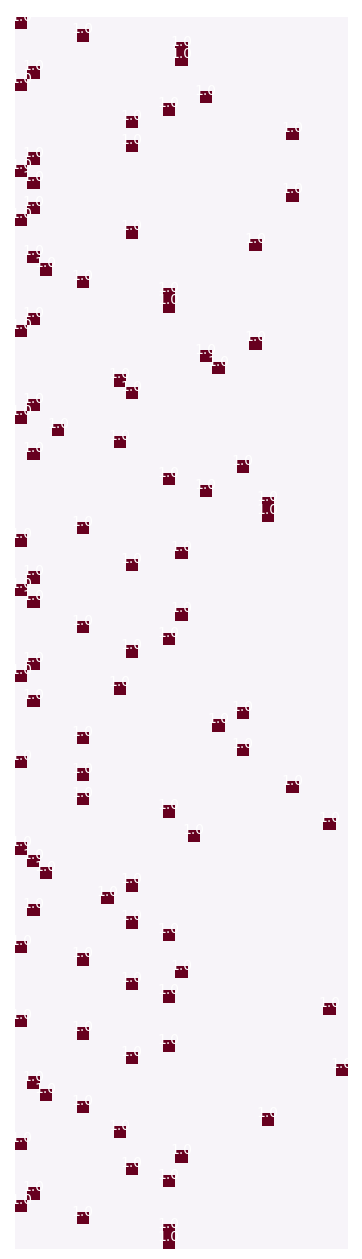

In [28]:
# # Plot it
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(16,16))
# plt.imshow(xenc[:100], cmap='PuRd')
# for i in range(100):
#     for j in range(xenc.shape[1]):
#         if xenc[i][j] == 1:
#             plt.text(j, i, xenc[i][j].item(), ha="center", va="bottom", color='white')
# plt.axis('off')

In [31]:
#randomly initialize 27 neurons' weights. Each neuron receives 27 inputs 
W = torch.randn((27,27), generator=g)

In [33]:
import torch.nn.functional as F

# Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # predict log-counts
counts = logits.exp() # exp to get counts, equivalent to probability N matrix above
probs = counts / counts.sum(1, keepdims = True) # probabilities for the next character
probs.shape

torch.Size([228146, 27])

In [41]:

# Let's take 'emma' 5-bigram example
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item() #input character index
    y = ys[i].item() #label character index
    p = probs[i,y]
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print(f'input to neural network: {x}')
    print(f'output probabilities from NN: {probs[i]}')
    print(f'label (actual next character): {y}')
    print(f'output probability     : {p}')
    print(f'prob from NN on correct character: {p.item()}')
    logp = torch.log(p)
    print(f'log likelihood         : {logp.item()}')
    nll = -logp
    print(f'negative loglikelihood (NLL): {nll.item()}')
    nlls[i] = nll
print(f'average negative log likelihood, i.e. loss = {nlls.mean().item()}')
          
    

bigram example 1: .e (indexes 0,5)
input to neural network: 0
output probabilities from NN: tensor([0.0510, 0.0251, 0.0217, 0.0191, 0.0094, 0.0318, 0.0140, 0.0175, 0.0241,
        0.0106, 0.0146, 0.0103, 0.1133, 0.0187, 0.1414, 0.0142, 0.0269, 0.0202,
        0.0147, 0.0050, 0.0401, 0.0286, 0.0965, 0.1209, 0.0759, 0.0110, 0.0235])
label (actual next character): 5
output probability     : 0.031783945858478546
prob from NN on correct character: 0.031783945858478546
log likelihood         : -3.448793888092041
negative loglikelihood (NLL): 3.448793888092041
bigram example 2: em (indexes 5,13)
input to neural network: 5
output probabilities from NN: tensor([0.0135, 0.0113, 0.0092, 0.0081, 0.0218, 0.0119, 0.0053, 0.1434, 0.0093,
        0.0076, 0.0603, 0.2522, 0.0332, 0.0143, 0.0143, 0.0062, 0.0014, 0.0009,
        0.0558, 0.0133, 0.0226, 0.0132, 0.0546, 0.0442, 0.0048, 0.0173, 0.1498])
label (actual next character): 13
output probability     : 0.014293731190264225
prob from NN on correct ch

In [45]:
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

In [55]:
#randomly initialize 27 neurons' weights. Each neuron receives 27 inputs 
W = torch.randn((27,27), generator=g, requires_grad=True)


In [82]:
# Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # predict log-counts
counts = logits.exp() # exp to get counts, equivalent to probability N matrix above
probs = counts / counts.sum(1, keepdims = True) # probabilities for the next character
loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()
print(loss.item())

3.785154342651367


In [83]:
#backward pass
W.grad = None # efficiently set the gradients to zero.
loss.backward()


In [84]:
#update gradients
W.data += -0.1 * W.grad

In [125]:
# putting it all together

#initialize
#randomly initialize 27 neurons' weights. Each neuron receives 27 inputs 
W = torch.randn((27,27), generator=g, requires_grad=True)

losses = []
lrate = []
learning_rate = 1
max_iterations = 1000
for k in range(max_iterations):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # exp to get counts, equivalent to probability N matrix above
    probs = counts / counts.sum(1, keepdims = True) # probabilities for the next character
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()
    
    #backward pass
    W.grad = None # efficiently set the gradients to zero.
    loss.backward()
    
    #update gradients
    W.data += -(10*learning_rate) * W.grad
    
    #update learning rate 
    learning_rate  = 1 - 0.9*k/max_iterations
    lrate.append(10*learning_rate)
    losses.append(loss.item())

print(f'\nloss : {losses[-1]}')



loss : 2.47235369682312


<Figure size 1600x1600 with 0 Axes>

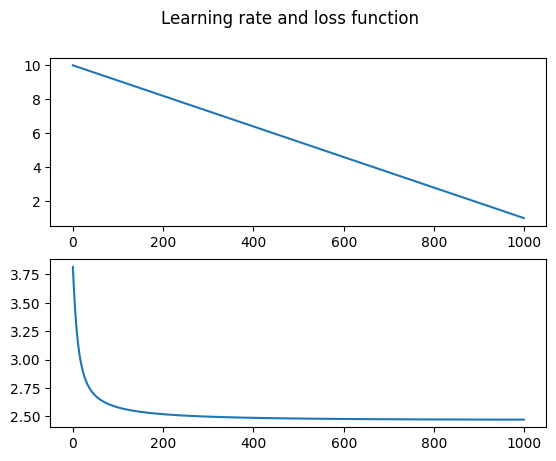

In [126]:
plt.figure(figsize=(16,16))
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss function')
axs[0].plot(lrate)
axs[1].plot(losses)

(-0.5, 26.5, 26.5, -0.5)

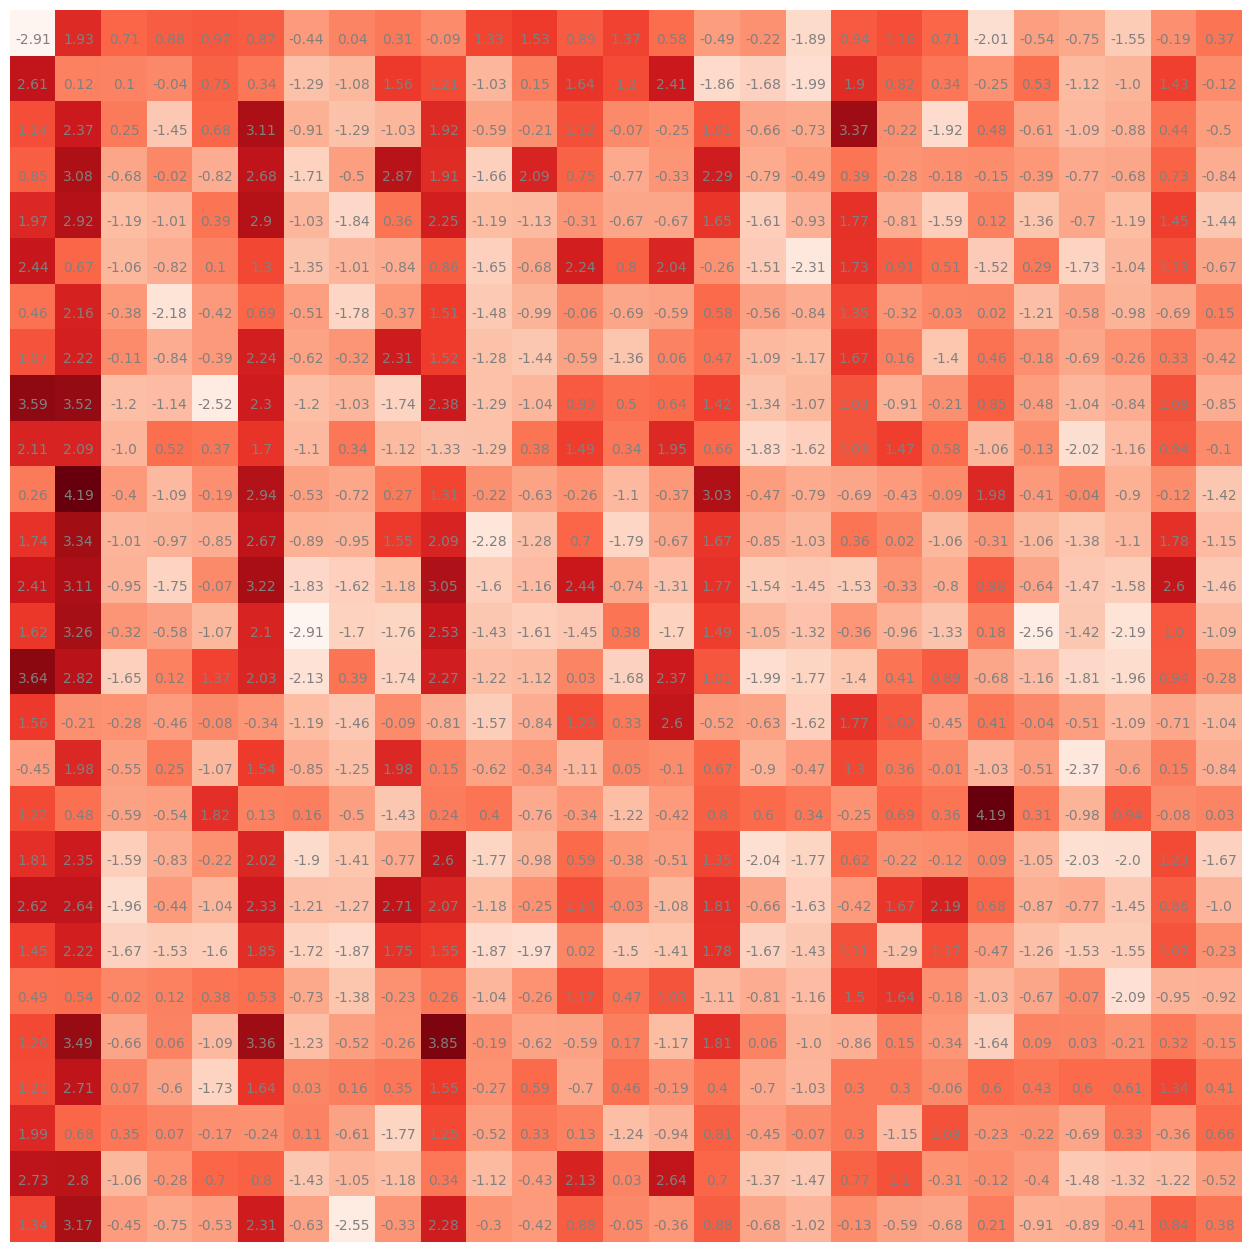

In [127]:
plt.figure(figsize=(16,16))
plt.imshow(W.detach().numpy(),cmap='Reds')
for i in range(27):
    for j in range(27):
        plt.text(j, i, str(round(W[i,j].item(),2)), ha="center", va="top", color='gray')
plt.axis('off')

In [128]:
# Sample the neural net model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if (ix == 0):
            break
    print(''.join(out))
    
                         


mor.
axx.
minaymoryles.
kondmaisah.
anchthizarie.
